In [2]:
# Load TensorBoard Logs (or http://localhost:6006)
%load_ext tensorboard
# %tensorboard --logdir callbacks/logs

In [3]:
# Define current working directory for the notebook
import os
os.getcwd()

'/home/jupyter'

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.8.0


In [5]:
# 1 CPU with 15GB RAM and 2 GPUs (NVIDIA Tesla T4) attached
tf.config.list_physical_devices()

2022-04-18 15:19:25.752604: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 15:19:25.753114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 15:19:25.766161: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 15:19:25.766612: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 15:19:25.767294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [ ]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

In [ ]:
# To only allocate necessary memory (to avoid memory outage)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [8]:
from tensorflow.python.data.util import options as options_lib
from tensorflow.data.experimental import DistributeOptions, AutoShardPolicy

DistributeOptions.auto_shard_policy = options_lib.create_option(
    name="auto_shard_policy",
    ty=AutoShardPolicy,
    docstring="The type of sharding to use. See "
    "`tf.data.experimental.AutoShardPolicy` for additional information.",
    default_factory=lambda: AutoShardPolicy.DATA)

In [9]:
# List available GPU resources
!nvidia-smi

Mon Apr 18 15:19:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    29W /  70W |  14885MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [11]:
# Load all libraries and custom functions from another notebook
%run Custom_Functions.ipynb
path_to_cwd = os.getcwd()

NumPy 1.19.5
Pandas 1.3.5
SciPy 1.7.3
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.2
Pydot 1.4.2
Pillow Version: 9.0.1
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
----------------------------------------------------------------------


# Pipeline : Baseline SCV -- Cluster

In [ ]:
# Load all libraries and custom functions from another notebook
%run Custom_Functions.ipynb
path_to_cwd = os.getcwd()
start = time()

# >> Step 1: load metadata
json_key_path = 'tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path) 


# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1] # 4809
trim_df = trim(train_df, max_samples, target_col)

# >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (100,100) # or what I want
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 6: Convert aug_train_df into X_train, y_train arrays
X_train = img_from_df_to_array(img_col=train_df_balanced.file_path)
y_train = train_df_balanced.label
print_in_color(f'\nX_train shape: {X_train.shape} \ny_train shape: {y_train.shape}\n',(255,0,255),(55,65,80))

# >> Step 7: Convert val_df into X_val and y_val arrays, rezise and rescale
X_val = img_from_df_to_array(img_col=val_df.file_path)
y_val = val_df.label
print_in_color(f'\nX_val shape: {X_val.shape} \ny_val shape: {y_val.shape}\n',(255,0,255),(55,65,80))

# >> Step 8: Flatten images into 2D array
X_train = X_train.reshape((len(X_train), -1))
X_val = X_val.reshape((len(X_val), -1))

# >> Step 8: Encode target to 1D array
y_train = LabelEncoder().fit_transform(y_train)
y_val = LabelEncoder().fit_transform(y_val)
print_in_color(f'\nShape of X_train and y_train after flattening and encoding:',(0,255,255),(55,65,80))
print(f'X_train shape: {X_train.shape}\ny_train shape:{y_train.shape}')
print_in_color(f'\nShape of X_val and y_val after flattening and encoding:',(0,255,255),(55,65,80))
print(f'X_val shape: {X_val.shape}\ny_val shape:{y_val.shape}\n')

# >> Step 9: Train model with BayesSearchCV
cv = 3 # 3
n_iter = 10 # 10
n_points = 10 # num settings in parallel

search_results = train_svc_hpo(X_train, y_train, cv=cv, n_iter=n_iter, n_points=n_points)  
# >> Step 10: Evaluate Baseline model
baseline_results_df = evaluate_baseline(search_results, X_train, y_train, X_val, y_val)
    
    
# >> Step 10: Evaluate Baseline model
baseline_results_df = evaluate_baseline(search_results, X_train, y_train, X_val, y_val)

# Total pipeline duration
baseline_tuned_SM = (time()-start)/60 # 320 min (10K)
print_in_color(f'\nElasped time for the entire "baseline_tuned_SM" : {baseline_tuned_SM:.2f} min',(0,255,0),(55,65,80))
%chime

# Pipeline : Untuned basic -- Cluster

In [9]:
# Define distributed strategy
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [10]:
# Load all libraries and custom functions from another notebook
%run Custom_Functions.ipynb
path_to_cwd = os.getcwd()
start = time()

# >> Step 1: load metadata
json_key_path = 'tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path) 

# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1] # 4809
trim_df = trim(train_df, max_samples, target_col)

# >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (300,300) # or what I want
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 5: Train Generator: Data Augmentation (on-the-fly)
batch_size = 64
global_batch_size = 64 * strategy.num_replicas_in_sync # For distributed training

image_col = train_df_balanced.columns[0]
img_size = (300,300) # the max with my GPU
img_format = metadata.file_format[0]
img_np = metadata.image_data_grayscale
num_channels = img_np.shape[-1] if img_np.ndim == 3 else 1
img_shape = (img_size[0], img_size[1], num_channels)
train_generator = train_gen(train_df_balanced,image_col,target_col,img_format,img_size,img_shape,num_channels,global_batch_size)

# >> Step 6: Val Generator: Rescale and Resize only
val_generator = val_gen(val_df,image_col,target_col,img_format,img_size,img_shape,num_channels,global_batch_size) 

# >> Step 7: Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='untuned_cluster')

NumPy 1.19.5
Pandas 1.3.5
SciPy 1.7.3
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.2
Pydot 1.4.2
Pillow Version: 9.0.1
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
----------------------------------------------------------------------

The shape of the merged_df is:
 (21165, 2)

After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    

Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Normal             4809
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: lab

  0%|          | 0/4 [00:00<?, ?it/s]

Found 1076 validated image filenames.
Found 2893 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Normal             4809
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

Viral_Pneumonia    4809
COVID              4809
Normal             4809
Lung_Opacity       4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 

Found 19236 validated image filenames belonging to 4 classes.

Number of images in the balanced train_generator:

19236

List of classes in the train_generator:

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

Few examples of OHE labels in the train_generator:

[3, 0, 2, 2, 3, 0, 3, 3, 3, 1, 0, 2, 0, 2, 3, 3, 0, 0, 3, 1] 

Found 2116 validated image filenames belonging to 4 classes.

val_generator

In [11]:
# >> Step 8: Convert generator to TF dataset
train_gen_ds = dataset_from_gen(train_generator, batch_size)
val_gen_ds = dataset_from_gen(val_generator, batch_size)

# Set the sharding policy to DATA
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_gen_ds.with_options(options)
val_gen_ds.with_options(options)

# >> Step 9: Create model within a mirrored strategy
model = create_cnn_cluster()


generator shape and dtypes BEFORE conversion:


images.shape:  (128, 300, 300, 1) 
images.dtype: float32
labels.shape:  (128, 4) 
labels.dtype: float32
--> type:  <class 'keras.preprocessing.image.DataFrameIterator'>
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')

TF dataset shape and dtypes AFTER conversion:


images.shape:  (128, 300, 300, 1) 
images.dtype: <dtype: 'float32'>
labels.shape:  (128, 4) 
labels.dtype: float32
--> type:  <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
(TensorSpec(shape=(128, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128, 4), dtype=tf.float32, name=None))

generator shape and dtypes BEFORE conversion:


images.shape:  (128, 300, 300, 1) 
images.dtype: float32
labels.shape:  (128, 4) 
labels.dtype: float32
--> type:  <class 'keras.preprocessing.image.DataFrameIterator'>
INFO:tensorflow:Using MirroredStrategy with devices (

<_OptionsDataset element_spec=(TensorSpec(shape=(128, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128, 4), dtype=tf.float32, name=None))>

<_OptionsDataset element_spec=(TensorSpec(shape=(128, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(128, 4), dtype=tf.float32, name=None))>

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:


Model training using the best hyperparameters started...



2022-04-18 10:39:06.303649: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "UnbatchDataset/_4"
op: "UnbatchDataset"
input: "MapDataset/_3"
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\020UnbatchDataset:3"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 300
        }
        dim {
          size: 300
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args 

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 30 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 30 all-reduces with algorithm = nccl, num_packs = 1


2022-04-18 10:39:15.934288: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-04-18 10:39:16.887407: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


150/150 [==============================] - ETA: 0s - loss: 0.7544 - accuracy: 0.6930 - recall: 0.6149

2022-04-18 10:44:24.795502: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "UnbatchDataset/_4"
op: "UnbatchDataset"
input: "MapDataset/_3"
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021UnbatchDataset:11"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 300
        }
        dim {
          size: 300
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 4
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_FLOAT
      type: DT_FLOAT
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args


Epoch 1: val_loss improved from inf to 2.73974, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep01-loss2.74.hdf5

val/train loss ratio: 3.63



2022-04-18 10:45:12.956443: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_26653"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:51"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -

150/150 [==============================] - 372s 2s/step - loss: 0.7544 - accuracy: 0.6930 - recall: 0.6149 - val_loss: 2.7397 - val_accuracy: 0.2827 - val_recall: 0.2817 - lr: 0.0040
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.7798 - recall: 0.7336
Epoch 2: val_loss improved from 2.73974 to 2.22629, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep02-loss2.23.hdf5

val/train loss ratio: 4.01



2022-04-18 10:47:53.025923: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_46191"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\021FlatMapDataset:89"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: -

150/150 [==============================] - 159s 1s/step - loss: 0.5557 - accuracy: 0.7798 - recall: 0.7336 - val_loss: 2.2263 - val_accuracy: 0.3052 - val_recall: 0.2754 - lr: 0.0040
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.8261 - recall: 0.7965
Epoch 3: val_loss improved from 2.22629 to 0.97987, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep03-loss0.98.hdf5

val/train loss ratio: 2.16



2022-04-18 10:50:30.555069: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_65225"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:127"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 

150/150 [==============================] - 157s 1s/step - loss: 0.4538 - accuracy: 0.8261 - recall: 0.7965 - val_loss: 0.9799 - val_accuracy: 0.6201 - val_recall: 0.5938 - lr: 0.0040
Epoch 4/50
150/150 [==============================] - ETA: 0s - loss: 0.3930 - accuracy: 0.8516 - recall: 0.8323
Epoch 4: val_loss improved from 0.97987 to 0.82255, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep04-loss0.82.hdf5

val/train loss ratio: 2.09



2022-04-18 10:53:06.843493: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_84259"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:165"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size: 

150/150 [==============================] - 156s 1s/step - loss: 0.3930 - accuracy: 0.8516 - recall: 0.8323 - val_loss: 0.8226 - val_accuracy: 0.6440 - val_recall: 0.6074 - lr: 0.0040
Epoch 5/50
150/150 [==============================] - ETA: 0s - loss: 0.3385 - accuracy: 0.8744 - recall: 0.8607
Epoch 5: val_loss did not improve from 0.82255

val/train loss ratio: 4.60



2022-04-18 10:55:42.925743: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_102917"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:203"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.3385 - accuracy: 0.8744 - recall: 0.8607 - val_loss: 1.5573 - val_accuracy: 0.5337 - val_recall: 0.5278 - lr: 0.0040
Epoch 6/50
150/150 [==============================] - ETA: 0s - loss: 0.3167 - accuracy: 0.8834 - recall: 0.8725
Epoch 6: val_loss improved from 0.82255 to 0.66147, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep06-loss0.66.hdf5

val/train loss ratio: 2.09



2022-04-18 10:58:20.144938: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_121951"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:241"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 157s 1s/step - loss: 0.3167 - accuracy: 0.8834 - recall: 0.8725 - val_loss: 0.6615 - val_accuracy: 0.7544 - val_recall: 0.7344 - lr: 0.0040
Epoch 7/50
150/150 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8950 - recall: 0.8868
Epoch 7: val_loss did not improve from 0.66147

val/train loss ratio: 8.71



2022-04-18 11:00:55.928376: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_140609"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:279"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.2844 - accuracy: 0.8950 - recall: 0.8868 - val_loss: 2.4755 - val_accuracy: 0.3989 - val_recall: 0.3965 - lr: 0.0040
Epoch 8/50
150/150 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.8997 - recall: 0.8916
Epoch 8: val_loss did not improve from 0.66147

val/train loss ratio: 3.89



2022-04-18 11:03:31.105004: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_159267"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:317"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 155s 1s/step - loss: 0.2729 - accuracy: 0.8997 - recall: 0.8916 - val_loss: 1.0627 - val_accuracy: 0.5522 - val_recall: 0.5464 - lr: 0.0040
Epoch 9/50
150/150 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.9064 - recall: 0.8991
Epoch 9: val_loss improved from 0.66147 to 0.50853, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep09-loss0.51.hdf5

val/train loss ratio: 2.01



2022-04-18 11:06:07.353576: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_178301"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:355"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.2535 - accuracy: 0.9064 - recall: 0.8991 - val_loss: 0.5085 - val_accuracy: 0.8076 - val_recall: 0.7866 - lr: 0.0040
Epoch 10/50
150/150 [==============================] - ETA: 0s - loss: 0.2419 - accuracy: 0.9110 - recall: 0.9054
Epoch 10: val_loss did not improve from 0.50853

val/train loss ratio: 2.81



2022-04-18 11:08:43.303370: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_196959"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:393"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.2419 - accuracy: 0.9110 - recall: 0.9054 - val_loss: 0.6806 - val_accuracy: 0.7290 - val_recall: 0.7227 - lr: 0.0040
Epoch 11/50
150/150 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9160 - recall: 0.9110
Epoch 11: val_loss improved from 0.50853 to 0.44515, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep11-loss0.45.hdf5

val/train loss ratio: 1.92



2022-04-18 11:11:18.817753: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_215993"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:431"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 155s 1s/step - loss: 0.2324 - accuracy: 0.9160 - recall: 0.9110 - val_loss: 0.4452 - val_accuracy: 0.8418 - val_recall: 0.8325 - lr: 0.0040
Epoch 12/50
150/150 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.9173 - recall: 0.9127
Epoch 12: val_loss did not improve from 0.44515

val/train loss ratio: 7.63



2022-04-18 11:13:54.641645: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_234651"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:469"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.2225 - accuracy: 0.9173 - recall: 0.9127 - val_loss: 1.6970 - val_accuracy: 0.5620 - val_recall: 0.5518 - lr: 0.0040
Epoch 13/50
150/150 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.9253 - recall: 0.9214
Epoch 13: val_loss did not improve from 0.44515

val/train loss ratio: 2.17



2022-04-18 11:16:31.866062: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_253309"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:507"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 157s 1s/step - loss: 0.2070 - accuracy: 0.9253 - recall: 0.9214 - val_loss: 0.4496 - val_accuracy: 0.8271 - val_recall: 0.8174 - lr: 0.0040
Epoch 14/50
150/150 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9261 - recall: 0.9227
Epoch 14: val_loss did not improve from 0.44515

val/train loss ratio: 4.72



2022-04-18 11:19:08.016289: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_271976"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:545"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.2038 - accuracy: 0.9261 - recall: 0.9227 - val_loss: 0.9620 - val_accuracy: 0.7139 - val_recall: 0.7002 - lr: 0.0040
Epoch 15/50
150/150 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9374 - recall: 0.9341
Epoch 15: val_loss improved from 0.44515 to 0.22560, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep15-loss0.23.hdf5

val/train loss ratio: 1.32



2022-04-18 11:21:44.069534: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_291010"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:583"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1708 - accuracy: 0.9374 - recall: 0.9341 - val_loss: 0.2256 - val_accuracy: 0.9116 - val_recall: 0.9097 - lr: 4.0000e-04
Epoch 16/50
150/150 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9424 - recall: 0.9404
Epoch 16: val_loss improved from 0.22560 to 0.20025, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep16-loss0.20.hdf5

val/train loss ratio: 1.27



2022-04-18 11:24:21.458316: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_310044"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:621"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 157s 1s/step - loss: 0.1583 - accuracy: 0.9424 - recall: 0.9404 - val_loss: 0.2003 - val_accuracy: 0.9248 - val_recall: 0.9209 - lr: 4.0000e-04
Epoch 17/50
150/150 [==============================] - ETA: 0s - loss: 0.1565 - accuracy: 0.9427 - recall: 0.9408
Epoch 17: val_loss improved from 0.20025 to 0.18819, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep17-loss0.19.hdf5

val/train loss ratio: 1.20



2022-04-18 11:26:57.618588: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_329078"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:659"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1565 - accuracy: 0.9427 - recall: 0.9408 - val_loss: 0.1882 - val_accuracy: 0.9272 - val_recall: 0.9238 - lr: 4.0000e-04
Epoch 18/50
150/150 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9458 - recall: 0.9440
Epoch 18: val_loss did not improve from 0.18819

val/train loss ratio: 1.60



2022-04-18 11:29:33.943928: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_347736"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:697"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1499 - accuracy: 0.9458 - recall: 0.9440 - val_loss: 0.2404 - val_accuracy: 0.9146 - val_recall: 0.9111 - lr: 4.0000e-04
Epoch 19/50
150/150 [==============================] - ETA: 0s - loss: 0.1451 - accuracy: 0.9483 - recall: 0.9456
Epoch 19: val_loss did not improve from 0.18819

val/train loss ratio: 1.43



2022-04-18 11:32:10.293549: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_366394"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:735"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1451 - accuracy: 0.9483 - recall: 0.9456 - val_loss: 0.2070 - val_accuracy: 0.9272 - val_recall: 0.9272 - lr: 4.0000e-04
Epoch 20/50
150/150 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.9470 - recall: 0.9456
Epoch 20: val_loss did not improve from 0.18819

val/train loss ratio: 1.45



2022-04-18 11:34:46.373399: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_385061"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:773"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1462 - accuracy: 0.9470 - recall: 0.9456 - val_loss: 0.2123 - val_accuracy: 0.9282 - val_recall: 0.9263 - lr: 4.0000e-04
Epoch 21/50
150/150 [==============================] - ETA: 0s - loss: 0.1455 - accuracy: 0.9461 - recall: 0.9439
Epoch 21: val_loss did not improve from 0.18819

val/train loss ratio: 1.33



2022-04-18 11:37:22.308674: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_403719"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:811"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1455 - accuracy: 0.9461 - recall: 0.9439 - val_loss: 0.1936 - val_accuracy: 0.9282 - val_recall: 0.9272 - lr: 4.0000e-05
Epoch 22/50
150/150 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9489 - recall: 0.9470
Epoch 22: val_loss did not improve from 0.18819

val/train loss ratio: 1.36



2022-04-18 11:39:58.054083: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_422377"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:849"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1409 - accuracy: 0.9489 - recall: 0.9470 - val_loss: 0.1915 - val_accuracy: 0.9316 - val_recall: 0.9312 - lr: 4.0000e-05
Epoch 23/50
150/150 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9507 - recall: 0.9492
Epoch 23: val_loss improved from 0.18819 to 0.18495, saving model to /home/jupyter/callbacks/untuned_cluster_best_weights-ep23-loss0.18.hdf5

val/train loss ratio: 1.35



2022-04-18 11:42:34.497802: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_441232"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:887"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1370 - accuracy: 0.9507 - recall: 0.9492 - val_loss: 0.1850 - val_accuracy: 0.9351 - val_recall: 0.9351 - lr: 4.0000e-05
Epoch 24/50
150/150 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9497 - recall: 0.9481
Epoch 24: val_loss did not improve from 0.18495

val/train loss ratio: 1.36



2022-04-18 11:45:10.909655: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_459890"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:925"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1373 - accuracy: 0.9497 - recall: 0.9481 - val_loss: 0.1873 - val_accuracy: 0.9355 - val_recall: 0.9346 - lr: 4.0000e-06
Epoch 25/50
150/150 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9501 - recall: 0.9485
Epoch 25: val_loss did not improve from 0.18495

val/train loss ratio: 1.37



2022-04-18 11:47:46.747741: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_478548"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\022FlatMapDataset:963"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size:

150/150 [==============================] - 156s 1s/step - loss: 0.1381 - accuracy: 0.9501 - recall: 0.9485 - val_loss: 0.1892 - val_accuracy: 0.9351 - val_recall: 0.9346 - lr: 4.0000e-06
Epoch 26/50
150/150 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9502 - recall: 0.9487
Epoch 26: val_loss did not improve from 0.18495

val/train loss ratio: 1.34



2022-04-18 11:50:22.982636: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_497215"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1001"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size

150/150 [==============================] - 156s 1s/step - loss: 0.1403 - accuracy: 0.9502 - recall: 0.9487 - val_loss: 0.1885 - val_accuracy: 0.9341 - val_recall: 0.9331 - lr: 4.0000e-06
Epoch 27/50
150/150 [==============================] - ETA: 0s - loss: 0.1408 - accuracy: 0.9501 - recall: 0.9485
Epoch 27: val_loss did not improve from 0.18495

val/train loss ratio: 1.34



2022-04-18 11:52:59.322296: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_516179"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:1039"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size

150/150 [==============================] - 157s 1s/step - loss: 0.1408 - accuracy: 0.9501 - recall: 0.9485 - val_loss: 0.1889 - val_accuracy: 0.9336 - val_recall: 0.9331 - lr: 4.0000e-07
Elasped time : 74.02 min

The entire model was saved in the saved_models folder as:

untuned_basic_cluster.h5

Class file was saved in the saved_models folder as:

class_df_untuned_basic_cluster_model.csv 


Performance Metrics from best_epoch for 
	"Untuned basic Model (cluster)"	


    Train Accuracy: 		95.1%
    Validation Accuracy: 	93.5%
    Train Recall: 		0.95
    Validation Recall: 		0.94
    Train Loss: 		0.14
    Validation Loss: 		0.18
    

Elasped time for the entire "pipeline_untuned_cluster" : 77.12 min


--------------- Learning Curves and Recall ---------------

 Best epoch = 24 



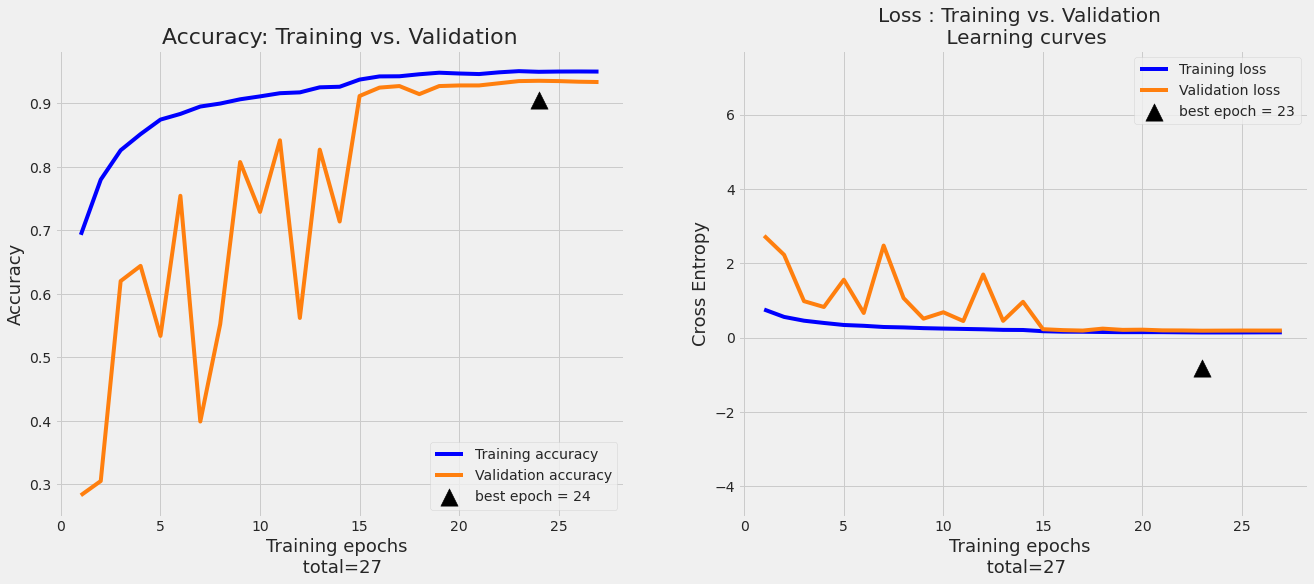

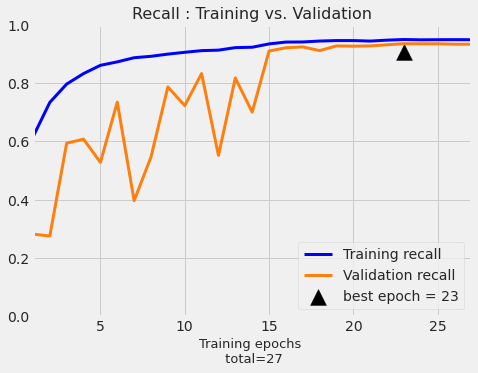

In [12]:
# >> Step 10: Fit model
epochs = 50 # 2
model, history = train_model_gen_ds(model, train_gen_ds, val_gen_ds, epochs)

# >> Step 11: Save model
model_name = 'untuned_basic_cluster'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)

# >> Step 12: Evaluate basic model
model_name = 'Untuned basic Model (cluster)'
name = 'untuned'
untuned_results_df =  metrics_train_val(history, model_name, name, index_name='Untuned Basic (cluster)') # save results

# Total pipeline duration
pipeline_untuned_cluster = (time()-start)/60 # 4 min
print_in_color(f'\nElasped time for the entire "pipeline_untuned_cluster" : {pipeline_untuned_cluster:.2f} min',(0,255,0),(55,65,80))

# >> Step 13: Plot learning curves and Recall
plot_learning_curve_and_recall(history)
%chime

# Pipeline: Tuned model -- GS -- Cluster

## 1. Data prep

In [9]:
# Load all libraries and custom functions from another notebook
%run Custom_Functions.ipynb 
path_to_cwd = os.getcwd()
start = time()

# >> Step 1: load metadata
json_key_path = 'tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path) 

# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1] # 4809
trim_df = trim(train_df, max_samples, target_col)

# >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (100,100) # the max with my local GPU
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 6: Convert aug_train_df into array
X_train = img_from_df_to_array(img_col=train_df_balanced.file_path)
y_train = tf.keras.utils.to_categorical(y=train_df_balanced.label.factorize()[0])
print_in_color(f'\nX_train shape: {X_train.shape} \ny_train shape: {y_train.shape}\n',(255,0,255),(55,65,80))

# >> Step 7: Train Generator: Data Augmentation (on-the-fly)
#batch_size = 64
batch_size = 64 * strategy.num_replicas_in_sync # For distributed training
img_np = metadata.image_data_grayscale
num_channels = img_np.shape[-1] if img_np.ndim == 3 else 1
img_shape = (img_size[0], img_size[1], num_channels)
train_generator = train_gen(train_df_balanced,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size)

# >> Step 8: Val Generator: Rescale and Resize only
val_generator = val_gen(val_df,image_col,target_col,img_format,img_size,img_shape,num_channels,batch_size) 

# >> Step 9: Convert val generator into array
X_val = np.concatenate([val_generator.next()[0] for i in range(val_generator.__len__())])
y_val = np.concatenate([val_generator.next()[1] for i in range(val_generator.__len__())])
print_in_color('\nValidation data from val_generator after conversion to numpy array:',(0,255,255),(55,65,80))
print_in_color(f'\nX_val shape: {X_val.shape} \ny_val shape: {y_val.shape}\n',(255,0,255),(55,65,80))

# >> Step 10: Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='GS_cluster')

NumPy 1.19.5
Pandas 1.3.5
SciPy 1.7.3
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.2
Pydot 1.4.2
Pillow Version: 9.0.1
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
----------------------------------------------------------------------

The shape of the merged_df is:
 (21165, 2)

After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    

Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: lab

  0%|          | 0/4 [00:00<?, ?it/s]

Found 2893 validated image filenames.
Found 1076 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Lung_Opacity       4809
Normal             4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

Lung_Opacity       4809
COVID              4809
Viral_Pneumonia    4809
Normal             4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 


Original and augmented images converted to numpy array:

All images are now in <class 'numpy.ndarray'>
Number of images = 19236
Shape of images: (19236, 100, 100, 1)

X_train shape: (19236, 100, 100, 1) 
y_train shape: (19236, 4)


Found 19236 validated image filenames belonging to 4 classes.

Number of images in the balanced train_generator:

19236

List of classes in the train_generator:

['COVID', 'Lu

## 2. Model tuning & training

In [10]:
# >> Step 11: Create KerasClassifer Wrapper and start GridSearch
epochs = 1    # going through the entire dataset once
cv = 3    # 5; default: StratifiedKFold

In [ ]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    grid_results = kerasclassifier_GS(cnn_model_gs, cv, epochs)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')

GridSearch hyperparameters tuning started...

Number of grid hyperparameters combinations: 729
Total number of models that will be fitted using GridSearchCV: 2187
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/devi

2022-04-17 15:13:26.707672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-04-17 15:13:27.682996: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200



val/train loss ratio: 0.67

1/1 [==============================] - 0s 105ms/step - loss: 1.3835 - accuracy: 0.1765 - recall: 0.0000e+00
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1

val/train loss ratio: 0.88

1/1 [==============================] - 0s 106ms/step - loss: 1.3778 - accuracy: 0.2941 - recall: 0.0000e+00
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1

val/train loss ratio: 0.71

1/1 [==============================] - 0s 108ms/step - loss: 1.5117 - accuracy: 0.1176 - recall: 0.0000e+00
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = nccl, num_packs = 1

val/train loss ratio: 0.91

1/1 [==============================] - 0s 15

In [14]:
# >> Step 12: Print best HP results
best_hps = grid_cv_results(grid_results)

# >> Step 13: Fit best_model_GS
epochs = 50  # 50
model = grid_results.best_estimator_.model 
model, history = train_model_gen(model, train_generator, val_generator, epochs)
%chime


Optimal hyperparameters with GridSearch:

FILTERS : 64
FILTERS_INPUT : 32
NUM_LAYER_CONV : 5
NUM_LAYER_DENSE : 3
RATE : 0.2
UNITS : 128

Giving a model accuracy (validation set):

32.9 %

For more details, below are all hyperparameters combinations searched and their relative accuracy (training set):


29.2% with:
	FILTERS : 64
	FILTERS_INPUT : 32
	NUM_LAYER_CONV : 3
	NUM_LAYER_DENSE : 2
	RATE : 0.0
	UNITS : 64

29.2% with:
	FILTERS : 64
	FILTERS_INPUT : 32
	NUM_LAYER_CONV : 3
	NUM_LAYER_DENSE : 2
	RATE : 0.0
	UNITS : 128

29.2% with:
	FILTERS : 64
	FILTERS_INPUT : 32
	NUM_LAYER_CONV : 3
	NUM_LAYER_DENSE : 2
	RATE : 0.0
	UNITS : 256

8.3% with:
	FILTERS : 64
	FILTERS_INPUT : 32
	NUM_LAYER_CONV : 3
	NUM_LAYER_DENSE : 2
	RATE : 0.2
	UNITS : 64

25.0% with:
	FILTERS : 64
	FILTERS_INPUT : 32
	NUM_LAYER_CONV : 3
	NUM_LAYER_DENSE : 2
	RATE : 0.2
	UNITS : 128

20.8% with:
	FILTERS : 64
	FILTERS_INPUT : 32
	NUM_LAYER_CONV : 3
	NUM_LAYER_DENSE : 2
	RATE : 0.2
	UNITS : 256

25.0% with:
	FILTERS

2022-04-18 05:58:44.484870: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72109123"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:355639"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

Epoch 1/50
150/150 [==============================] - ETA: 0s - loss: 0.2789 - accuracy: 0.8981 - recall: 0.8897

2022-04-18 05:59:30.274743: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72110376"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:355667"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          


Epoch 1: val_loss did not improve from 0.33583

val/train loss ratio: 1.33



2022-04-18 05:59:35.034120: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72132734"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:355695"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 55s 363ms/step - loss: 0.2789 - accuracy: 0.8981 - recall: 0.8897 - val_loss: 0.3722 - val_accuracy: 0.8486 - val_recall: 0.8418 - lr: 4.0000e-08
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.2784 - accuracy: 0.8984 - recall: 0.8894
Epoch 2: val_loss did not improve from 0.33583

val/train loss ratio: 1.40



2022-04-18 06:00:26.281425: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72156000"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:355752"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 50s 336ms/step - loss: 0.2784 - accuracy: 0.8984 - recall: 0.8894 - val_loss: 0.3911 - val_accuracy: 0.8428 - val_recall: 0.8354 - lr: 4.0000e-08
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.9006 - recall: 0.8901
Epoch 3: val_loss did not improve from 0.33583

val/train loss ratio: 1.42



2022-04-18 06:01:15.178643: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72179266"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:355809"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 49s 325ms/step - loss: 0.2762 - accuracy: 0.9006 - recall: 0.8901 - val_loss: 0.3918 - val_accuracy: 0.8438 - val_recall: 0.8369 - lr: 4.0000e-08
Epoch 4/50
150/150 [==============================] - ETA: 0s - loss: 0.2760 - accuracy: 0.8998 - recall: 0.8910
Epoch 4: val_loss did not improve from 0.33583

val/train loss ratio: 1.42



2022-04-18 06:02:03.573385: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72202541"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:355866"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 48s 322ms/step - loss: 0.2760 - accuracy: 0.8998 - recall: 0.8910 - val_loss: 0.3919 - val_accuracy: 0.8438 - val_recall: 0.8369 - lr: 4.0000e-08
Epoch 5/50
150/150 [==============================] - ETA: 0s - loss: 0.2801 - accuracy: 0.8984 - recall: 0.8892
Epoch 5: val_loss did not improve from 0.33583

val/train loss ratio: 1.40



2022-04-18 06:02:51.540054: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72225807"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:355923"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 48s 319ms/step - loss: 0.2801 - accuracy: 0.8984 - recall: 0.8892 - val_loss: 0.3910 - val_accuracy: 0.8433 - val_recall: 0.8354 - lr: 4.0000e-09
Epoch 6/50
150/150 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8977 - recall: 0.8877
Epoch 6: val_loss did not improve from 0.33583

val/train loss ratio: 1.39



2022-04-18 06:03:39.862518: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72249073"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:355980"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 48s 322ms/step - loss: 0.2820 - accuracy: 0.8977 - recall: 0.8877 - val_loss: 0.3928 - val_accuracy: 0.8433 - val_recall: 0.8359 - lr: 4.0000e-09
Epoch 7/50
150/150 [==============================] - ETA: 0s - loss: 0.2776 - accuracy: 0.8988 - recall: 0.8910
Epoch 7: val_loss did not improve from 0.33583

val/train loss ratio: 1.41



2022-04-18 06:04:28.290691: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72272348"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:356037"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 48s 323ms/step - loss: 0.2776 - accuracy: 0.8988 - recall: 0.8910 - val_loss: 0.3929 - val_accuracy: 0.8438 - val_recall: 0.8354 - lr: 4.0000e-09
Epoch 8/50
150/150 [==============================] - ETA: 0s - loss: 0.2807 - accuracy: 0.8998 - recall: 0.8916
Epoch 8: val_loss did not improve from 0.33583

val/train loss ratio: 1.40



2022-04-18 06:05:16.635316: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72295614"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:356094"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 48s 321ms/step - loss: 0.2807 - accuracy: 0.8998 - recall: 0.8916 - val_loss: 0.3916 - val_accuracy: 0.8428 - val_recall: 0.8364 - lr: 4.0000e-10
Epoch 9/50
150/150 [==============================] - ETA: 0s - loss: 0.2755 - accuracy: 0.8979 - recall: 0.8893
Epoch 9: val_loss did not improve from 0.33583

val/train loss ratio: 1.42



2022-04-18 06:06:04.795803: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72318880"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:356151"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 48s 320ms/step - loss: 0.2755 - accuracy: 0.8979 - recall: 0.8893 - val_loss: 0.3915 - val_accuracy: 0.8442 - val_recall: 0.8364 - lr: 4.0000e-10
Epoch 10/50
150/150 [==============================] - ETA: 0s - loss: 0.2846 - accuracy: 0.8972 - recall: 0.8881
Epoch 10: val_loss did not improve from 0.33583

val/train loss ratio: 1.39



2022-04-18 06:06:52.747324: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72342155"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:356208"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 48s 319ms/step - loss: 0.2846 - accuracy: 0.8972 - recall: 0.8881 - val_loss: 0.3952 - val_accuracy: 0.8418 - val_recall: 0.8345 - lr: 4.0000e-10
Epoch 11/50
150/150 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8986 - recall: 0.8895
Epoch 11: val_loss did not improve from 0.33583

val/train loss ratio: 1.40



2022-04-18 06:07:41.233403: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_72365811"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025FlatMapDataset:356265"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          

150/150 [==============================] - 48s 322ms/step - loss: 0.2802 - accuracy: 0.8986 - recall: 0.8895 - val_loss: 0.3935 - val_accuracy: 0.8442 - val_recall: 0.8369 - lr: 4.0000e-11
Elasped time : 9.04 min


## 3. Model evaluation


Performance Metrics from best_epoch for 
	"Tuned_GS CNN Model"	


    Train Accuracy: 		89.8%
    Validation Accuracy: 	84.9%
    Train Recall: 		0.89
    Validation Recall: 		0.84
    Train Loss: 		0.28
    Validation Loss: 		0.37
    

The entire model was saved in the saved_models folder as:

best_tuned_GS_cluster.h5

Class file was saved in the saved_models folder as:

class_df_best_tuned_GS_cluster_model.csv 


Elasped time for the entire "pipeline_kerasClassifier_GS_cluster" : 904.71 min


--------------- Learning Curves and Recall ---------------

 Best epoch = 1 



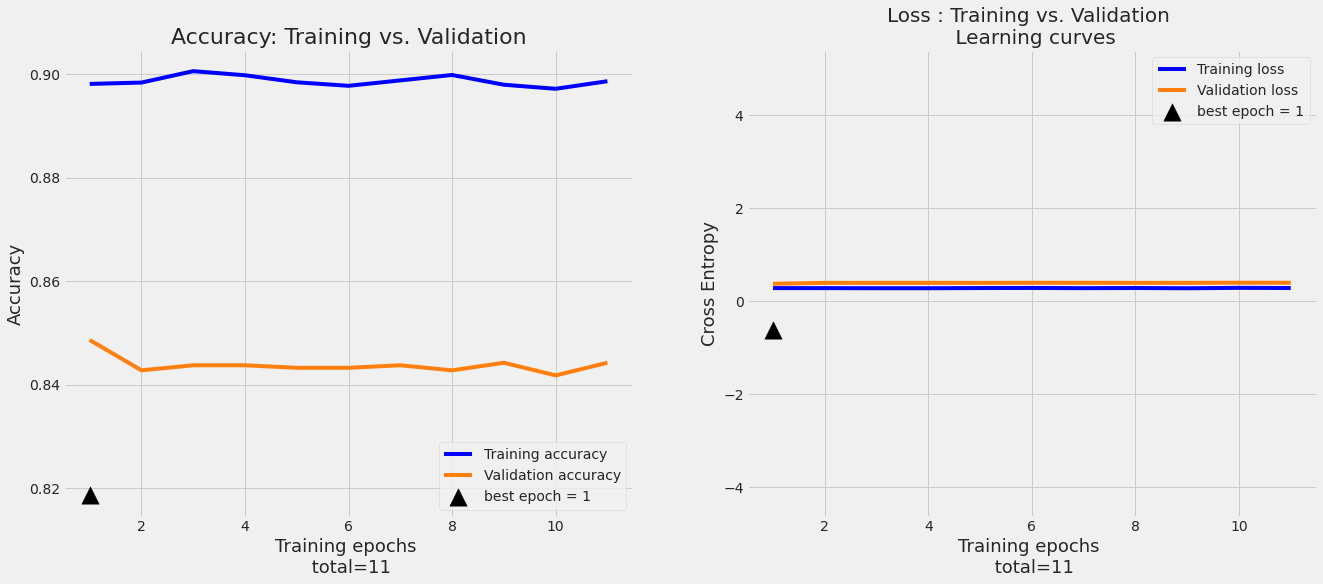

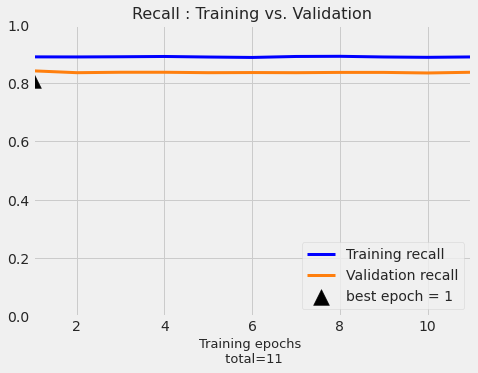

In [15]:
# >> Step 14: Evaluate best_model_GS
model_name = 'Tuned_GS CNN Model'
name = 'GS'
GS_results_df =  metrics_train_val(history, model_name, name, index_name='GridSearch (cluster)') # save results

# >> Step 15: Save model
model_name='best_tuned_GS_cluster'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)

# Total pipeline duration
pipeline_kerasClassifier_GS_cluster = (time()-start)/60
msg = f'\nElasped time for the entire "pipeline_kerasClassifier_GS_cluster" : {pipeline_kerasClassifier_GS_cluster:.2f} min'
print_in_color(msg,(0,255,0),(55,65,80))

# >> Step 16: Plot Learning Curve and Recall
plot_learning_curve_and_recall(history)

# Pipeline: Tuned model -- RS -- Cluster

## 1. Data prep

In [9]:
# Load all libraries and custom functions from another notebook
%run Custom_Functions.ipynb
path_to_cwd = os.getcwd()
start = time()

# >> Step 1: load metadata
json_key_path = 'tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path) 

# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1]
trim_df = trim(train_df, max_samples, target_col)

# >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (200,200) # or what I want
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 6: Train Generator: Data Augmentation (on-the-fly)
batch_size = 64 * strategy.num_replicas_in_sync # For distributed training
image_col = train_df_balanced.columns[0]
img_size = (200,200) # the max with local GPU (keep same for consistency SM vs cluster)
img_format = metadata.file_format[0]
img_np = metadata.image_data_grayscale
num_channels = img_np.shape[-1] if img_np.ndim == 3 else 1
img_shape = (img_size[0], img_size[1], num_channels)
train_generator = train_gen(train_df_balanced, image_col, target_col, img_format, img_size, img_shape, num_channels, batch_size)

# >> Step 7: Val Generator: Rescale and Resize only
val_generator = val_gen(val_df, image_col, target_col, img_format, img_size, img_shape, num_channels, batch_size) 

# >> Step 8: Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='RS_cluster')

NumPy 1.19.5
Pandas 1.3.5
SciPy 1.7.3
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.2
Pydot 1.4.2
Pillow Version: 9.0.1
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
----------------------------------------------------------------------

The shape of the merged_df is:
 (21165, 2)

After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    

Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Normal             4809
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: lab

  0%|          | 0/4 [00:00<?, ?it/s]

Found 1076 validated image filenames.
Found 2893 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Normal             4809
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

COVID              4809
Lung_Opacity       4809
Normal             4809
Viral_Pneumonia    4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 

Found 19236 validated image filenames belonging to 4 classes.

Number of images in the balanced train_generator:

19236

List of classes in the train_generator:

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

Few examples of OHE labels in the train_generator:

[0, 0, 1, 1, 1, 0, 2, 3, 0, 3, 0, 2, 3, 0, 1, 2, 0, 3, 3, 1] 

Found 2116 validated image filenames belonging to 4 classes.

val_generator

## 2. Model tuning & training

In [10]:
# >> Step 9: Keras-Tuner RandomSearch
epochs = 3    # going through the entire dataset once
max_trials = 20 # 50
tuner = kerastuner_RS_cluster(kerastuner_cnn_model, max_trials, path_to_cwd)

# >> Step 10: Print best HP results
tuner_type = 'RandomSearch'
best_hps = kerastuner_results(tuner, tuner_type=tuner_type)

Trial 20 Complete [00h 04m 19s]
val_accuracy: 0.4844045341014862

Best val_accuracy So Far: 0.7197542786598206
Total elapsed time: 01h 29m 36s
INFO:tensorflow:Oracle triggered exit

Optimal hyperparameters with RandomSearch:


    Number of filters in input layer 	64

    Number of Conv2D layer(s) 		5
    Number of Dense layer(s) 		3
    Dropout 				0.1

    
The hyperparameter search is complete. 
List of all best hyperparameters with RandomSearch:

{'dropout_rate': 0.1,
 'n_filters_conv_2': 64,
 'n_filters_conv_3': 256,
 'n_filters_conv_4': 128,
 'n_filters_conv_5': 64,
 'n_filters_conv_6': 256,
 'n_filters_input': 64,
 'n_layers_conv': 5,
 'n_layers_dense': 3,
 'n_nodes_dense_1': 192,
 'n_nodes_dense_2': 192,
 'n_nodes_dense_3': 128,
 'n_nodes_dense_4': 128,
 'pooling_conv_2': 'max',
 'pooling_conv_3': 'avg',
 'pooling_conv_4': 'avg',
 'pooling_conv_5': 'avg',
 'pooling_conv_6': 'max'}
------------------------------------------------------------


In [11]:
strategy = tf.distribute.MirroredStrategy()

# >> Step 11: Re-build the model using the best HP
with strategy.scope():
    model = tuner.hypermodel.build(best_hps)
    
get_kerastuner_structure(tuner, tuner_type=tuner_type) # show model structure

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')

Architecture of the best model with RandomSearch:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 filters_conv_input (Conv2D)  (None, 200, 200, 64)     1664      
                                                                 
 norm_conv_input (BatchNorma  (None, 200, 200, 64)     256       
 lization)                                                       
                                                                 
 activation_conv_input (Acti  (None, 200, 200, 64)     0         
 vation)                                                         
                                                                 
 reducer_conv_input (MaxPool  (None, 100, 100, 64)     0         
 ing2D)                                              

In [12]:
# >> Step 12: Fit model
epochs = 50  # 50
model, history = train_model_gen(model, train_generator, val_generator, epochs)

%chime


Model training using the best hyperparameters started...



2022-04-16 14:05:26.921843: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_908571"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2281"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size

Epoch 1/50
150/150 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.6890 - recall: 0.6164

2022-04-16 14:06:52.006877: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_918933"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2309"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size


Epoch 1: val_loss improved from inf to 3.02904, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep01-loss3.03.hdf5

val/train loss ratio: 4.07



2022-04-16 14:06:59.130717: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_942546"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2337"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size

150/150 [==============================] - 98s 603ms/step - loss: 0.7449 - accuracy: 0.6890 - recall: 0.6164 - val_loss: 3.0290 - val_accuracy: 0.2988 - val_recall: 0.2925 - lr: 0.0040
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.5805 - accuracy: 0.7662 - recall: 0.7207
Epoch 2: val_loss improved from 3.02904 to 2.42367, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep02-loss2.42.hdf5

val/train loss ratio: 4.18



2022-04-16 14:08:27.920424: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_966916"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2394"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size

150/150 [==============================] - 87s 576ms/step - loss: 0.5805 - accuracy: 0.7662 - recall: 0.7207 - val_loss: 2.4237 - val_accuracy: 0.3315 - val_recall: 0.3164 - lr: 0.0040
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.5084 - accuracy: 0.7995 - recall: 0.7667
Epoch 3: val_loss did not improve from 2.42367

val/train loss ratio: 6.40



2022-04-16 14:09:54.907330: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_990190"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2451"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          size

150/150 [==============================] - 87s 578ms/step - loss: 0.5084 - accuracy: 0.7995 - recall: 0.7667 - val_loss: 3.2515 - val_accuracy: 0.2324 - val_recall: 0.2236 - lr: 0.0040
Epoch 4/50
150/150 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.8303 - recall: 0.8052
Epoch 4: val_loss improved from 2.42367 to 2.19523, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep04-loss2.20.hdf5

val/train loss ratio: 4.95



2022-04-16 14:11:21.940063: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1013944"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2508"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 579ms/step - loss: 0.4439 - accuracy: 0.8303 - recall: 0.8052 - val_loss: 2.1952 - val_accuracy: 0.2559 - val_recall: 0.2041 - lr: 0.0040
Epoch 5/50
150/150 [==============================] - ETA: 0s - loss: 0.3982 - accuracy: 0.8469 - recall: 0.8278
Epoch 5: val_loss improved from 2.19523 to 1.75094, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep05-loss1.75.hdf5

val/train loss ratio: 4.40



2022-04-16 14:12:48.444783: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1037698"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2565"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 574ms/step - loss: 0.3982 - accuracy: 0.8469 - recall: 0.8278 - val_loss: 1.7509 - val_accuracy: 0.3657 - val_recall: 0.3286 - lr: 0.0040
Epoch 6/50
150/150 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.8571 - recall: 0.8416
Epoch 6: val_loss improved from 1.75094 to 0.80891, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep06-loss0.81.hdf5

val/train loss ratio: 2.16



2022-04-16 14:14:15.386201: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1061452"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2622"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 578ms/step - loss: 0.3738 - accuracy: 0.8571 - recall: 0.8416 - val_loss: 0.8089 - val_accuracy: 0.7163 - val_recall: 0.7056 - lr: 0.0040
Epoch 7/50
150/150 [==============================] - ETA: 0s - loss: 0.3235 - accuracy: 0.8770 - recall: 0.8656
Epoch 7: val_loss did not improve from 0.80891

val/train loss ratio: 7.95



2022-04-16 14:15:41.633372: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1084726"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2679"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 573ms/step - loss: 0.3235 - accuracy: 0.8770 - recall: 0.8656 - val_loss: 2.5719 - val_accuracy: 0.2847 - val_recall: 0.2759 - lr: 0.0040
Epoch 8/50
150/150 [==============================] - ETA: 0s - loss: 0.3157 - accuracy: 0.8824 - recall: 0.8720
Epoch 8: val_loss improved from 0.80891 to 0.47783, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep08-loss0.48.hdf5

val/train loss ratio: 1.51



2022-04-16 14:17:08.978688: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1108480"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2736"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 582ms/step - loss: 0.3157 - accuracy: 0.8824 - recall: 0.8720 - val_loss: 0.4778 - val_accuracy: 0.8188 - val_recall: 0.8101 - lr: 0.0040
Epoch 9/50
150/150 [==============================] - ETA: 0s - loss: 0.2876 - accuracy: 0.8942 - recall: 0.8851
Epoch 9: val_loss did not improve from 0.47783

val/train loss ratio: 4.68



2022-04-16 14:18:35.290580: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1131754"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2793"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 573ms/step - loss: 0.2876 - accuracy: 0.8942 - recall: 0.8851 - val_loss: 1.3472 - val_accuracy: 0.5298 - val_recall: 0.5117 - lr: 0.0040
Epoch 10/50
150/150 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.8976 - recall: 0.8904
Epoch 10: val_loss did not improve from 0.47783

val/train loss ratio: 2.61



2022-04-16 14:20:02.097078: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1155028"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2850"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 580ms/step - loss: 0.2708 - accuracy: 0.8976 - recall: 0.8904 - val_loss: 0.7058 - val_accuracy: 0.7485 - val_recall: 0.7314 - lr: 0.0040
Epoch 11/50
150/150 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9041 - recall: 0.8976
Epoch 11: val_loss did not improve from 0.47783

val/train loss ratio: 5.82



2022-04-16 14:21:29.110962: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1178311"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2907"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 576ms/step - loss: 0.2521 - accuracy: 0.9041 - recall: 0.8976 - val_loss: 1.4673 - val_accuracy: 0.4561 - val_recall: 0.4312 - lr: 0.0040
Epoch 12/50
150/150 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 0.9265 - recall: 0.9219
Epoch 12: val_loss improved from 0.47783 to 0.27193, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep12-loss0.27.hdf5

val/train loss ratio: 1.35



2022-04-16 14:22:55.419764: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1202065"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2964"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 574ms/step - loss: 0.2019 - accuracy: 0.9265 - recall: 0.9219 - val_loss: 0.2719 - val_accuracy: 0.8989 - val_recall: 0.8970 - lr: 4.0000e-04
Epoch 13/50
150/150 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9287 - recall: 0.9252
Epoch 13: val_loss improved from 0.27193 to 0.25426, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep13-loss0.25.hdf5

val/train loss ratio: 1.34



2022-04-16 14:24:22.628611: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1225819"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3021"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 579ms/step - loss: 0.1899 - accuracy: 0.9287 - recall: 0.9252 - val_loss: 0.2543 - val_accuracy: 0.9038 - val_recall: 0.8960 - lr: 4.0000e-04
Epoch 14/50
150/150 [==============================] - ETA: 0s - loss: 0.1747 - accuracy: 0.9349 - recall: 0.9319
Epoch 14: val_loss improved from 0.25426 to 0.21287, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep14-loss0.21.hdf5

val/train loss ratio: 1.22



2022-04-16 14:25:48.370504: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1249573"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3078"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 571ms/step - loss: 0.1747 - accuracy: 0.9349 - recall: 0.9319 - val_loss: 0.2129 - val_accuracy: 0.9263 - val_recall: 0.9224 - lr: 4.0000e-04
Epoch 15/50
150/150 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9354 - recall: 0.9314
Epoch 15: val_loss improved from 0.21287 to 0.20341, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep15-loss0.20.hdf5

val/train loss ratio: 1.16



2022-04-16 14:27:15.346070: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1273087"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3135"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 576ms/step - loss: 0.1753 - accuracy: 0.9354 - recall: 0.9314 - val_loss: 0.2034 - val_accuracy: 0.9272 - val_recall: 0.9248 - lr: 4.0000e-04
Epoch 16/50
150/150 [==============================] - ETA: 0s - loss: 0.1745 - accuracy: 0.9341 - recall: 0.9312
Epoch 16: val_loss improved from 0.20341 to 0.19751, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep16-loss0.20.hdf5

val/train loss ratio: 1.13



2022-04-16 14:28:42.544518: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1296841"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3192"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 580ms/step - loss: 0.1745 - accuracy: 0.9341 - recall: 0.9312 - val_loss: 0.1975 - val_accuracy: 0.9316 - val_recall: 0.9302 - lr: 4.0000e-04
Epoch 17/50
150/150 [==============================] - ETA: 0s - loss: 0.1714 - accuracy: 0.9370 - recall: 0.9345
Epoch 17: val_loss did not improve from 0.19751

val/train loss ratio: 1.29



2022-04-16 14:30:10.082993: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1320115"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3249"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 581ms/step - loss: 0.1714 - accuracy: 0.9370 - recall: 0.9345 - val_loss: 0.2217 - val_accuracy: 0.9185 - val_recall: 0.9160 - lr: 4.0000e-04
Epoch 18/50
150/150 [==============================] - ETA: 0s - loss: 0.1653 - accuracy: 0.9411 - recall: 0.9385
Epoch 18: val_loss improved from 0.19751 to 0.18524, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep18-loss0.19.hdf5

val/train loss ratio: 1.12



2022-04-16 14:31:36.114121: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1343869"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3306"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 572ms/step - loss: 0.1653 - accuracy: 0.9411 - recall: 0.9385 - val_loss: 0.1852 - val_accuracy: 0.9302 - val_recall: 0.9277 - lr: 4.0000e-04
Epoch 19/50
150/150 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9399 - recall: 0.9381
Epoch 19: val_loss did not improve from 0.18524

val/train loss ratio: 1.49



2022-04-16 14:33:03.161637: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1367143"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3363"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 579ms/step - loss: 0.1595 - accuracy: 0.9399 - recall: 0.9381 - val_loss: 0.2371 - val_accuracy: 0.9141 - val_recall: 0.9131 - lr: 4.0000e-04
Epoch 20/50
150/150 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9411 - recall: 0.9384
Epoch 20: val_loss did not improve from 0.18524

val/train loss ratio: 2.09



2022-04-16 14:34:29.833823: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1390417"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3420"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 576ms/step - loss: 0.1609 - accuracy: 0.9411 - recall: 0.9384 - val_loss: 0.3357 - val_accuracy: 0.8647 - val_recall: 0.8608 - lr: 4.0000e-04
Epoch 21/50
150/150 [==============================] - ETA: 0s - loss: 0.1569 - accuracy: 0.9431 - recall: 0.9401
Epoch 21: val_loss did not improve from 0.18524

val/train loss ratio: 1.33



2022-04-16 14:35:56.902345: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1413700"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3477"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 578ms/step - loss: 0.1569 - accuracy: 0.9431 - recall: 0.9401 - val_loss: 0.2088 - val_accuracy: 0.9268 - val_recall: 0.9248 - lr: 4.0000e-04
Epoch 22/50
150/150 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9452 - recall: 0.9433
Epoch 22: val_loss did not improve from 0.18524

val/train loss ratio: 1.25



2022-04-16 14:37:23.459671: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1436974"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3534"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 573ms/step - loss: 0.1495 - accuracy: 0.9452 - recall: 0.9433 - val_loss: 0.1864 - val_accuracy: 0.9312 - val_recall: 0.9297 - lr: 4.0000e-05
Epoch 23/50
150/150 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9454 - recall: 0.9431
Epoch 23: val_loss improved from 0.18524 to 0.18047, saving model to /home/jupyter/callbacks/RS_cluster_best_weights-ep23-loss0.18.hdf5

val/train loss ratio: 1.23



2022-04-16 14:38:50.462744: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1460488"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3591"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 578ms/step - loss: 0.1467 - accuracy: 0.9454 - recall: 0.9431 - val_loss: 0.1805 - val_accuracy: 0.9370 - val_recall: 0.9351 - lr: 4.0000e-05
Epoch 24/50
150/150 [==============================] - ETA: 0s - loss: 0.1491 - accuracy: 0.9440 - recall: 0.9422
Epoch 24: val_loss did not improve from 0.18047

val/train loss ratio: 1.31



2022-04-16 14:40:17.410201: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1483771"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3648"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 579ms/step - loss: 0.1491 - accuracy: 0.9440 - recall: 0.9422 - val_loss: 0.1948 - val_accuracy: 0.9302 - val_recall: 0.9272 - lr: 4.0000e-05
Epoch 25/50
150/150 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9461 - recall: 0.9442
Epoch 25: val_loss did not improve from 0.18047

val/train loss ratio: 1.26



2022-04-16 14:41:43.947345: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1507045"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3705"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 575ms/step - loss: 0.1489 - accuracy: 0.9461 - recall: 0.9442 - val_loss: 0.1879 - val_accuracy: 0.9331 - val_recall: 0.9312 - lr: 4.0000e-06
Epoch 26/50
150/150 [==============================] - ETA: 0s - loss: 0.1439 - accuracy: 0.9458 - recall: 0.9431
Epoch 26: val_loss did not improve from 0.18047

val/train loss ratio: 1.30



2022-04-16 14:43:11.798727: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1530319"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3762"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 88s 584ms/step - loss: 0.1439 - accuracy: 0.9458 - recall: 0.9431 - val_loss: 0.1873 - val_accuracy: 0.9346 - val_recall: 0.9331 - lr: 4.0000e-06
Epoch 27/50
150/150 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9464 - recall: 0.9446
Epoch 27: val_loss did not improve from 0.18047

val/train loss ratio: 1.27



2022-04-16 14:44:38.322908: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1553602"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3819"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 574ms/step - loss: 0.1468 - accuracy: 0.9464 - recall: 0.9446 - val_loss: 0.1863 - val_accuracy: 0.9346 - val_recall: 0.9326 - lr: 4.0000e-06
Epoch 28/50
150/150 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9466 - recall: 0.9446
Epoch 28: val_loss did not improve from 0.18047

val/train loss ratio: 1.30



2022-04-16 14:46:06.088725: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_1577266"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3876"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 88s 583ms/step - loss: 0.1440 - accuracy: 0.9466 - recall: 0.9446 - val_loss: 0.1872 - val_accuracy: 0.9336 - val_recall: 0.9326 - lr: 4.0000e-07
Elasped time : 40.77 min


## 3. Model evaluation


Performance Metrics from best_epoch for 
	"Tuned_RS_Cluster CNN Model"	


    Train Accuracy: 		94.5%
    Validation Accuracy: 	93.7%
    Train Recall: 		0.94
    Validation Recall: 		0.94
    Train Loss: 		0.15
    Validation Loss: 		0.18
    

The entire model was saved in the saved_models folder as:

best_tuned_RS_cluster.h5

Class file was saved in the saved_models folder as:

class_df_best_tuned_RS_cluster_model.csv 

Elasped time for the entire "pipeline_kerasTuner_RS_cluster" : 132.02 min


--------------- Learning Curves and Recall ---------------

 Best epoch = 23 



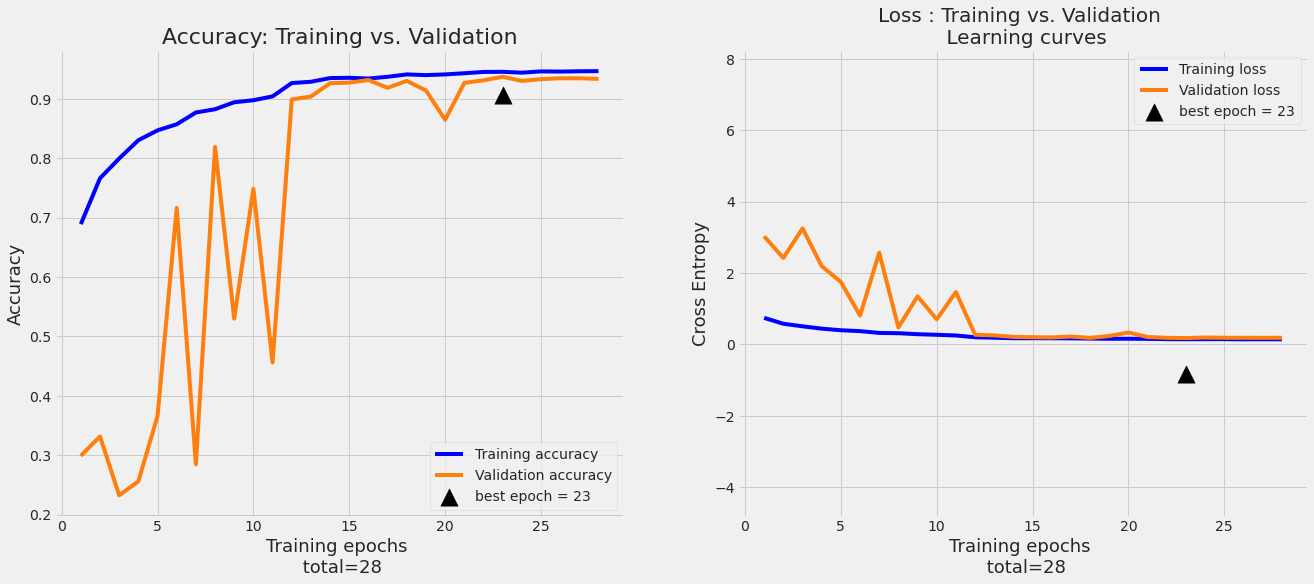

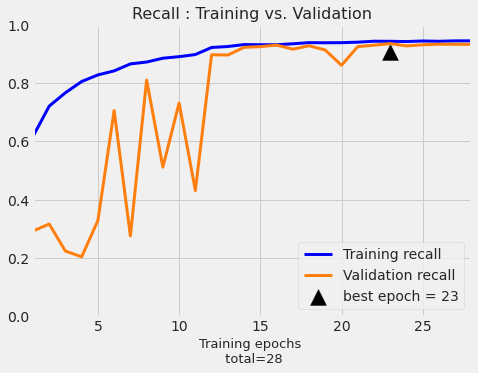

In [13]:
# >> Step 13: Evaluate tuned_RS model
model_name = 'Tuned_RS_Cluster CNN Model'
name = 'RS'
RS_results_df =  metrics_train_val(history, model_name, name, index_name='RandomSearch (cluster)') # create DF for RS results

# >> Step 14: Save model
model_name = 'best_tuned_RS_cluster'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)

# Total pipeline duration
pipeline_kerasTuner_RS_cluster = (time()-start)/60
print_in_color(f'Elasped time for the entire "pipeline_kerasTuner_RS_cluster" : {pipeline_kerasTuner_RS_cluster:.2f} min',(0,255,0),(55,65,80))

# >> Step 15: Plot learning curves and Recall
plot_learning_curve_and_recall(history)

# Pipeline: Tuned model -- BS -- Cluster

## 1. Data prep

In [9]:
# Load all libraries and custom functions from another notebook
%run Custom_Functions.ipynb
path_to_cwd = os.getcwd()
start = time()

# >> Step 1: load metadata
json_key_path = 'tranquil-lore-342617-05dea4250c64.json'
metadata = load_metadata_from_gcs(json_key_path) 

# >> Step 2: load and merge dataset
merged_df = load_and_merge(path_to_cwd)

# >> Step 3: Train/test split
target_col = metadata.columns[-1]
train_df, val_df, test_df = split_df(merged_df, target_col)

# >> Step 4: Data trimming
max_samples = train_df.label.value_counts()[1]
trim_df = trim(train_df, max_samples, target_col)

# >> Step 5: Data Augmentation (offline)
image_col = trim_df.columns[0]
img_size = (200,200) # the max with local GPU (keep same for consistency SM vs cluster)
img_format = metadata.file_format[0]
train_df_balanced = aug_train(trim_df, max_samples, image_col, target_col, img_size, img_format, path_to_cwd)

# >> Step 5: Train Generator: Data Augmentation (on-the-fly)
batch_size = 64 * strategy.num_replicas_in_sync # For distributed training
image_col = train_df_balanced.columns[0]
img_np = metadata.image_data_grayscale
num_channels = img_np.shape[-1] if img_np.ndim == 3 else 1
img_shape = (img_size[0], img_size[1], num_channels)
train_generator = train_gen(train_df_balanced, image_col, target_col, img_format, img_size, img_shape, num_channels, batch_size)

# >> Step 6: Val Generator: Rescale and Resize only
val_generator = val_gen(val_df, image_col, target_col, img_format, img_size, img_shape, num_channels, batch_size) 

# >> Step 7: Define callbacks
callback_hpo, callback_training = callbacks(path_to_cwd, name='BS_cluster')

NumPy 1.19.5
Pandas 1.3.5
SciPy 1.7.3
Scikit-Learn 1.0.2
scikit-optimize 0.9.0
Seaborn 0.11.2
Pydot 1.4.2
Pillow Version: 9.0.1
TF version 2.8.0
Keras version 2.8.0
Kerastuner 1.0.3
ray 1.11.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
----------------------------------------------------------------------

The shape of the merged_df is:
 (21165, 2)

After the split, listed below are the number of images in each set:


    Images in the training set: 	16932
    Images in the validation set: 	2116
    Images in the test set: 		2117
    

Original number of images in train_df:

16932

Number of images per Class in train_df

Normal             8154
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64

Number of images trimmed from the majority Class:

3345

Number of images per Class in trim_df

Normal             4809
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: lab

  0%|          | 0/4 [00:00<?, ?it/s]

Found 2893 validated image filenames.
Found 1076 validated image filenames.

Total images created in the aug_img folder:

5649 augmented images created

Number of images per Class in the trim_df before augmentation:

Normal             4809
Lung_Opacity       4809
COVID              2893
Viral_Pneumonia    1076
Name: label, dtype: int64 

Number of images per Class in the train_df_balanced after augmentation:

Normal             4809
Viral_Pneumonia    4809
COVID              4809
Lung_Opacity       4809
Name: label, dtype: int64 

Total number of images in train_df_balanced:

19236 

Found 19236 validated image filenames belonging to 4 classes.

Number of images in the balanced train_generator:

19236

List of classes in the train_generator:

['COVID', 'Lung_Opacity', 'Normal', 'Viral_Pneumonia']

Few examples of OHE labels in the train_generator:

[2, 3, 0, 1, 1, 3, 0, 3, 1, 0, 0, 0, 3, 2, 2, 2, 0, 3, 3, 3] 

Found 2116 validated image filenames belonging to 4 classes.

val_generator

## 2. Model tuning & training

In [10]:
# >> Step 9: Keras-Tuner BayesSearch
epochs = 3    # going through the entire dataset once
max_trials = 20    # 50
tuner = kerastuner_BS_cluster(kerastuner_cnn_model, max_trials, path_to_cwd)

# >> Step 10: Print best HP results
tuner_type = 'BayesSearch'
best_hps = kerastuner_results(tuner, tuner_type=tuner_type)

Trial 20 Complete [00h 04m 23s]
val_accuracy: 0.4031190872192383

Best val_accuracy So Far: 0.7112476229667664
Total elapsed time: 01h 32m 02s
INFO:tensorflow:Oracle triggered exit

Optimal hyperparameters with BayesSearch:


    Number of filters in input layer 	64

    Number of Conv2D layer(s) 		4
    Number of Dense layer(s) 		4
    Dropout 				0.2

    
The hyperparameter search is complete. 
List of all best hyperparameters with BayesSearch:

{'dropout_rate': 0.2,
 'n_filters_conv_2': 64,
 'n_filters_conv_3': 192,
 'n_filters_conv_4': 64,
 'n_filters_conv_5': 64,
 'n_filters_conv_6': 64,
 'n_filters_input': 64,
 'n_layers_conv': 4,
 'n_layers_dense': 4,
 'n_nodes_dense_1': 128,
 'n_nodes_dense_2': 192,
 'n_nodes_dense_3': 192,
 'n_nodes_dense_4': 64,
 'pooling_conv_2': 'max',
 'pooling_conv_3': 'max',
 'pooling_conv_4': 'avg',
 'pooling_conv_5': 'avg',
 'pooling_conv_6': 'avg'}
------------------------------------------------------------


In [11]:
# >> Step 11: Re-build the model using the best HP
strategy = tf.distribute.MirroredStrategy()

# >> Step 11: Re-build the model using the best HP
with strategy.scope():
    model = tuner.hypermodel.build(best_hps)
    
get_kerastuner_structure(tuner, tuner_type=tuner_type) # show model structure

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')

Architecture of the best model with BayesSearch:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 filters_conv_input (Conv2D)  (None, 200, 200, 64)     1664      
                                                                 
 norm_conv_input (BatchNorma  (None, 200, 200, 64)     256       
 lization)                                                       
                                                                 
 activation_conv_input (Acti  (None, 200, 200, 64)     0         
 vation)                                                         
                                                                 
 reducer_conv_input (MaxPool  (None, 100, 100, 64)     0         
 ing2D)                                               

In [12]:
# >> Step 12: Fit model
epochs = 50   # 50
model, history = train_model_gen(model, train_generator, val_generator, epochs)
%chime


Model training using the best hyperparameters started...

Epoch 1/50


2022-04-16 16:36:28.294593: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2217427"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2281"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - ETA: 0s - loss: 0.8266 - accuracy: 0.6517 - recall: 0.5536

2022-04-16 16:37:53.909871: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2227885"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2309"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz


Epoch 1: val_loss improved from inf to 1.57966, saving model to /home/jupyter/callbacks/BS_cluster_best_weights-ep01-loss1.58.hdf5

val/train loss ratio: 1.91



2022-04-16 16:38:00.953540: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2251630"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2337"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 98s 601ms/step - loss: 0.8266 - accuracy: 0.6517 - recall: 0.5536 - val_loss: 1.5797 - val_accuracy: 0.3301 - val_recall: 0.3115 - lr: 0.0040
Epoch 2/50
150/150 [==============================] - ETA: 0s - loss: 0.6363 - accuracy: 0.7422 - recall: 0.6832
Epoch 2: val_loss did not improve from 1.57966

val/train loss ratio: 2.81



2022-04-16 16:39:29.623441: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2275652"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2394"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 580ms/step - loss: 0.6363 - accuracy: 0.7422 - recall: 0.6832 - val_loss: 1.7892 - val_accuracy: 0.3608 - val_recall: 0.3359 - lr: 0.0040
Epoch 3/50
150/150 [==============================] - ETA: 0s - loss: 0.5502 - accuracy: 0.7833 - recall: 0.7406
Epoch 3: val_loss did not improve from 1.57966

val/train loss ratio: 5.24



2022-04-16 16:40:55.988596: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2299066"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2451"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 574ms/step - loss: 0.5502 - accuracy: 0.7833 - recall: 0.7406 - val_loss: 2.8818 - val_accuracy: 0.2939 - val_recall: 0.2886 - lr: 0.0040
Epoch 4/50
150/150 [==============================] - ETA: 0s - loss: 0.4985 - accuracy: 0.8057 - recall: 0.7745
Epoch 4: val_loss did not improve from 1.57966

val/train loss ratio: 7.07



2022-04-16 16:42:22.181337: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2322489"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2508"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 572ms/step - loss: 0.4985 - accuracy: 0.8057 - recall: 0.7745 - val_loss: 3.5259 - val_accuracy: 0.2676 - val_recall: 0.2549 - lr: 0.0040
Epoch 5/50
150/150 [==============================] - ETA: 0s - loss: 0.4067 - accuracy: 0.8501 - recall: 0.8246
Epoch 5: val_loss improved from 1.57966 to 1.57338, saving model to /home/jupyter/callbacks/BS_cluster_best_weights-ep05-loss1.57.hdf5

val/train loss ratio: 3.87



2022-04-16 16:43:48.476283: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2346143"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2565"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 574ms/step - loss: 0.4067 - accuracy: 0.8501 - recall: 0.8246 - val_loss: 1.5734 - val_accuracy: 0.4658 - val_recall: 0.4365 - lr: 4.0000e-04
Epoch 6/50
150/150 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.8564 - recall: 0.8351
Epoch 6: val_loss improved from 1.57338 to 1.36138, saving model to /home/jupyter/callbacks/BS_cluster_best_weights-ep06-loss1.36.hdf5

val/train loss ratio: 3.60



2022-04-16 16:45:16.159585: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2370037"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2622"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 88s 583ms/step - loss: 0.3786 - accuracy: 0.8564 - recall: 0.8351 - val_loss: 1.3614 - val_accuracy: 0.5044 - val_recall: 0.4697 - lr: 4.0000e-04
Epoch 7/50
150/150 [==============================] - ETA: 0s - loss: 0.3636 - accuracy: 0.8625 - recall: 0.8461
Epoch 7: val_loss improved from 1.36138 to 0.82010, saving model to /home/jupyter/callbacks/BS_cluster_best_weights-ep07-loss0.82.hdf5

val/train loss ratio: 2.26



2022-04-16 16:46:43.030179: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2393931"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2679"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 578ms/step - loss: 0.3636 - accuracy: 0.8625 - recall: 0.8461 - val_loss: 0.8201 - val_accuracy: 0.7109 - val_recall: 0.6943 - lr: 4.0000e-04
Epoch 8/50
150/150 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8712 - recall: 0.8544
Epoch 8: val_loss improved from 0.82010 to 0.36429, saving model to /home/jupyter/callbacks/BS_cluster_best_weights-ep08-loss0.36.hdf5

val/train loss ratio: 1.05



2022-04-16 16:48:10.314139: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2417825"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2736"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 579ms/step - loss: 0.3482 - accuracy: 0.8712 - recall: 0.8544 - val_loss: 0.3643 - val_accuracy: 0.8555 - val_recall: 0.8359 - lr: 4.0000e-04
Epoch 9/50
150/150 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8751 - recall: 0.8599
Epoch 9: val_loss did not improve from 0.36429

val/train loss ratio: 3.40



2022-04-16 16:49:36.715635: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2441239"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2793"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 574ms/step - loss: 0.3407 - accuracy: 0.8751 - recall: 0.8599 - val_loss: 1.1601 - val_accuracy: 0.6602 - val_recall: 0.6509 - lr: 4.0000e-04
Epoch 10/50
150/150 [==============================] - ETA: 0s - loss: 0.3359 - accuracy: 0.8729 - recall: 0.8586
Epoch 10: val_loss did not improve from 0.36429

val/train loss ratio: 1.19



2022-04-16 16:51:04.190943: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2464653"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2850"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 582ms/step - loss: 0.3359 - accuracy: 0.8729 - recall: 0.8586 - val_loss: 0.3983 - val_accuracy: 0.8491 - val_recall: 0.8364 - lr: 4.0000e-04
Epoch 11/50
150/150 [==============================] - ETA: 0s - loss: 0.3141 - accuracy: 0.8827 - recall: 0.8715
Epoch 11: val_loss did not improve from 0.36429

val/train loss ratio: 1.18



2022-04-16 16:52:30.542786: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2488076"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2907"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 574ms/step - loss: 0.3141 - accuracy: 0.8827 - recall: 0.8715 - val_loss: 0.3695 - val_accuracy: 0.8545 - val_recall: 0.8433 - lr: 4.0000e-04
Epoch 12/50
150/150 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.8859 - recall: 0.8738
Epoch 12: val_loss improved from 0.36429 to 0.34026, saving model to /home/jupyter/callbacks/BS_cluster_best_weights-ep12-loss0.34.hdf5

val/train loss ratio: 1.12



2022-04-16 16:53:57.478889: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2511970"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2964"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 578ms/step - loss: 0.3032 - accuracy: 0.8859 - recall: 0.8738 - val_loss: 0.3403 - val_accuracy: 0.8682 - val_recall: 0.8491 - lr: 4.0000e-05
Epoch 13/50
150/150 [==============================] - ETA: 0s - loss: 0.3026 - accuracy: 0.8865 - recall: 0.8749
Epoch 13: val_loss improved from 0.34026 to 0.32332, saving model to /home/jupyter/callbacks/BS_cluster_best_weights-ep13-loss0.32.hdf5

val/train loss ratio: 1.07



2022-04-16 16:55:24.905266: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2535864"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3021"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 580ms/step - loss: 0.3026 - accuracy: 0.8865 - recall: 0.8749 - val_loss: 0.3233 - val_accuracy: 0.8774 - val_recall: 0.8647 - lr: 4.0000e-05
Epoch 14/50
150/150 [==============================] - ETA: 0s - loss: 0.2991 - accuracy: 0.8890 - recall: 0.8774
Epoch 14: val_loss did not improve from 0.32332

val/train loss ratio: 1.10



2022-04-16 16:56:50.867537: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2559278"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3078"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 572ms/step - loss: 0.2991 - accuracy: 0.8890 - recall: 0.8774 - val_loss: 0.3294 - val_accuracy: 0.8740 - val_recall: 0.8618 - lr: 4.0000e-05
Epoch 15/50
150/150 [==============================] - ETA: 0s - loss: 0.3023 - accuracy: 0.8896 - recall: 0.8795
Epoch 15: val_loss improved from 0.32332 to 0.31881, saving model to /home/jupyter/callbacks/BS_cluster_best_weights-ep15-loss0.32.hdf5

val/train loss ratio: 1.05



2022-04-16 16:58:18.085346: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2582932"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3135"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 578ms/step - loss: 0.3023 - accuracy: 0.8896 - recall: 0.8795 - val_loss: 0.3188 - val_accuracy: 0.8760 - val_recall: 0.8643 - lr: 4.0000e-05
Epoch 16/50
150/150 [==============================] - ETA: 0s - loss: 0.2951 - accuracy: 0.8911 - recall: 0.8795
Epoch 16: val_loss did not improve from 0.31881

val/train loss ratio: 1.12



2022-04-16 16:59:44.659002: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2606355"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3192"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 575ms/step - loss: 0.2951 - accuracy: 0.8911 - recall: 0.8795 - val_loss: 0.3305 - val_accuracy: 0.8726 - val_recall: 0.8613 - lr: 4.0000e-05
Epoch 17/50
150/150 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8921 - recall: 0.8813
Epoch 17: val_loss did not improve from 0.31881

val/train loss ratio: 1.10



2022-04-16 17:01:11.501458: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2629769"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3249"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 577ms/step - loss: 0.2917 - accuracy: 0.8921 - recall: 0.8813 - val_loss: 0.3206 - val_accuracy: 0.8779 - val_recall: 0.8691 - lr: 4.0000e-06
Epoch 18/50
150/150 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.8936 - recall: 0.8827
Epoch 18: val_loss did not improve from 0.31881

val/train loss ratio: 1.10



2022-04-16 17:02:37.582305: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2653183"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3306"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 572ms/step - loss: 0.2904 - accuracy: 0.8936 - recall: 0.8827 - val_loss: 0.3202 - val_accuracy: 0.8789 - val_recall: 0.8701 - lr: 4.0000e-06
Epoch 19/50
150/150 [==============================] - ETA: 0s - loss: 0.2989 - accuracy: 0.8905 - recall: 0.8794
Epoch 19: val_loss did not improve from 0.31881

val/train loss ratio: 1.09



2022-04-16 17:04:05.084094: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2676606"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3363"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 88s 582ms/step - loss: 0.2989 - accuracy: 0.8905 - recall: 0.8794 - val_loss: 0.3245 - val_accuracy: 0.8760 - val_recall: 0.8691 - lr: 4.0000e-06
Epoch 20/50
150/150 [==============================] - ETA: 0s - loss: 0.2985 - accuracy: 0.8904 - recall: 0.8796
Epoch 20: val_loss did not improve from 0.31881

val/train loss ratio: 1.09



2022-04-16 17:05:32.139720: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2700020"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3420"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 87s 578ms/step - loss: 0.2985 - accuracy: 0.8904 - recall: 0.8796 - val_loss: 0.3255 - val_accuracy: 0.8760 - val_recall: 0.8667 - lr: 4.0000e-07
Epoch 21/50
150/150 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.8906 - recall: 0.8796
Epoch 21: val_loss did not improve from 0.31881

val/train loss ratio: 1.11



2022-04-16 17:06:58.114153: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2723434"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3477"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 574ms/step - loss: 0.2925 - accuracy: 0.8906 - recall: 0.8796 - val_loss: 0.3253 - val_accuracy: 0.8755 - val_recall: 0.8662 - lr: 4.0000e-07
Epoch 22/50
150/150 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.8936 - recall: 0.8828
Epoch 22: val_loss did not improve from 0.31881

val/train loss ratio: 1.12



2022-04-16 17:08:24.654923: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2746857"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3534"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 86s 572ms/step - loss: 0.2904 - accuracy: 0.8936 - recall: 0.8828 - val_loss: 0.3256 - val_accuracy: 0.8750 - val_recall: 0.8672 - lr: 4.0000e-07
Epoch 23/50
150/150 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.8904 - recall: 0.8797
Epoch 23: val_loss did not improve from 0.31881

val/train loss ratio: 1.10



2022-04-16 17:09:52.628241: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_2"
op: "FlatMapDataset"
input: "TensorDataset/_1"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_flat_map_fn_2770661"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:3591"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
        dim {
          size: -1
        }
      }
      shape {
        dim {
          size: -1
        }
        dim {
          siz

150/150 [==============================] - 88s 584ms/step - loss: 0.2948 - accuracy: 0.8904 - recall: 0.8797 - val_loss: 0.3250 - val_accuracy: 0.8760 - val_recall: 0.8662 - lr: 4.0000e-08
Elasped time : 33.51 min


## 3. Model evaluation


Performance Metrics from best_epoch for 
	"Tuned_BS_Cluster CNN Model"	


    Train Accuracy: 		89.0%
    Validation Accuracy: 	87.6%
    Train Recall: 		0.88
    Validation Recall: 		0.86
    Train Loss: 		0.30
    Validation Loss: 		0.32
    

The entire model was saved in the saved_models folder as:

best_tuned_BS_cluster.h5

Class file was saved in the saved_models folder as:

class_df_best_tuned_BS_cluster_model.csv 


Elasped time for the entire "pipeline_kerasTuner_BS_cluster" : 126.68 min


--------------- Learning Curves and Recall ---------------

 Best epoch = 18 



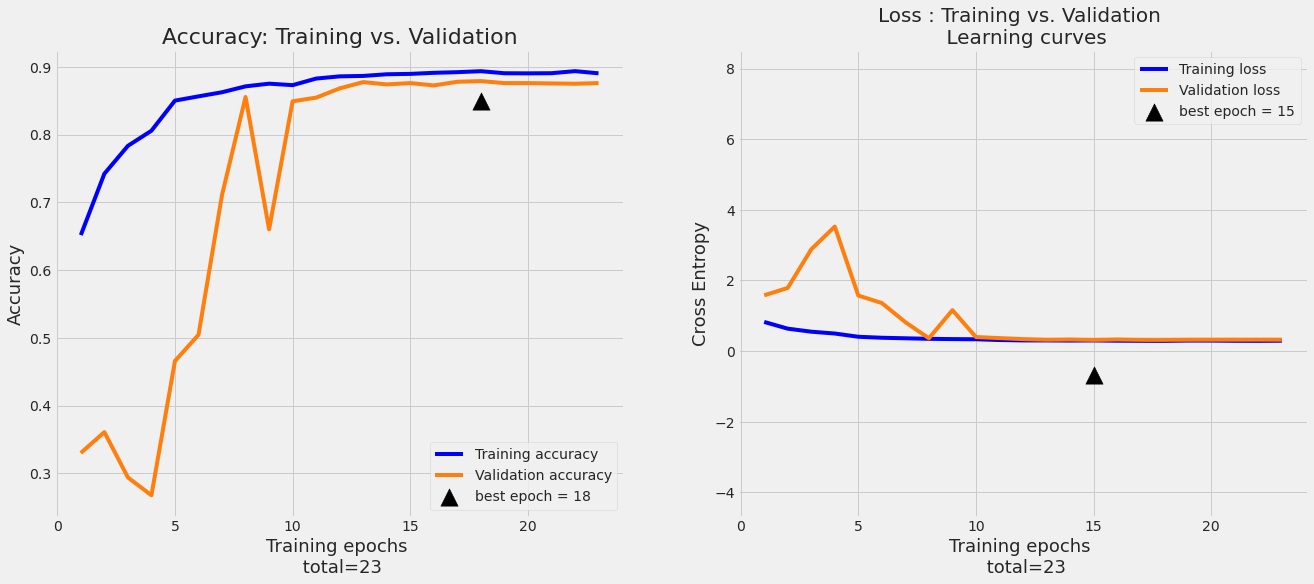

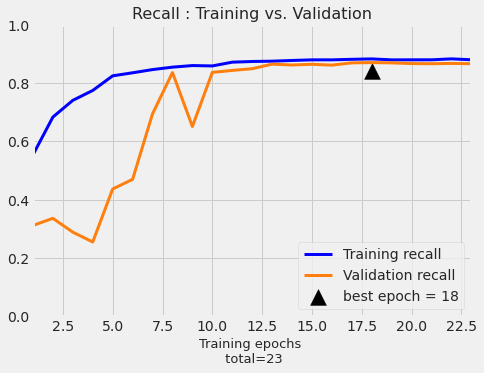

In [13]:
# >> Step 12: Evaluate tuned_BS model
model_name = 'Tuned_BS_Cluster CNN Model'
name = 'BS'
BS_results_df =  metrics_train_val(history, model_name, name, index_name='BayesSearch (cluster)') # save results

# >> Step 13: Save model
model_name = 'best_tuned_BS_cluster'
save_model_gen(model, model_name, train_generator, img_size, path_to_cwd, pixel_scaler=255)

# Total pipeline duration
pipeline_kerasTuner_BS_cluster = (time()-start)/60
print_in_color(f'\nElasped time for the entire "pipeline_kerasTuner_BS_cluster" : {pipeline_kerasTuner_BS_cluster:.2f} min',(0,255,0),(55,65,80))

# >> Step 14: Plot learning curves and Recall
plot_learning_curve_and_recall(history)

# Models Performance Comparison

In [12]:
# Upload results from all models
untuned_results_df = pd.read_csv('results/untuned_results_df.csv', index_col='model')
GS_results_df = pd.read_csv('results/GS_results_df.csv', index_col='model')
RS_results_df = pd.read_csv('results/RS_results_df.csv', index_col='model')
BS_results_df = pd.read_csv('results/BS_results_df.csv', index_col='model')


# ------------ Comparison 1: Performance metrics ------------
# Merge and save all results
print_in_color('\nPerformance metrics comparison between all models tested:',(0,255,255),(0,65,80))
results_df_cluster = pd.concat([untuned_results_df, GS_results_df, 
                                RS_results_df, BS_results_df], axis=0)

# Save merged results to a new file
results_df_cluster.to_csv('results/metrics_comparison_cluster.csv', index_label='model')

# Display results   
results_df_cluster2 = results_df_cluster \
            .style.highlight_min(subset=['Accuracy_train','Accuracy_val','Recall_train','Recall_val'], color='red', axis=0) \
            .highlight_max(subset=['Accuracy_train','Accuracy_val','Recall_train','Recall_val'], color='green', axis=0) \
            .highlight_min(subset=['Loss_train','Loss_val'], color='green', axis=0) \
            .highlight_max(subset=['Loss_train','Loss_val'], color='red', axis=0) 
results_df_cluster2


Performance metrics comparison between all models tested:



In [1]:
# ------------ Comparison 2: Total Pipeline Duration ------------
print_in_color('\n Total Pipeline duration comparison between all models tested: ',(0,255,255),(0,65,80))
print(f'''
> Basic Untuned CNN model: \t\t\t\t{pipeline_untuned_cluster:.1f} min
> HalvingGridSearchCV Pipeline with Keras Wrapper: \t{pipeline_kerasClassifier_GS_cluster:.1f} min
> RandomSearch Pipeline using Keras-Tuner: \t\t{pipeline_kerasTuner_RS_cluster:.1f} min
> BayesSearch Pipeline using Keras-Tuner: \t\t{pipeline_kerasTuner_BS_cluster:.1f} min
''')

# Save notebooks and results to GCP

In [14]:
# %%script False
json_key_path = 'tranquil-lore-342617-05dea4250c64.json'

# Get GCS bucket with the key
storage_client = storage.Client.from_service_account_json(json_key_path)
bucket_name = 'big_data_project_storage'
bucket = storage_client.get_bucket(bucket_name)

# Convert local files as blobs (file name to be used in the bucket)


# Upload to GCP (local file to be uploaded)


In [15]:
blob = bucket.blob('Yurie/results/metrics_comparison_cluster.csv') 
blob.upload_from_filename('results/metrics_comparison_cluster.csv')

In [16]:
blob = bucket.blob('Yurie/results/untuned_results_df.csv') 
blob.upload_from_filename('results/untuned_results_df.csv')

In [17]:
blob = bucket.blob('Yurie/results/GS_results_df.csv') 
blob.upload_from_filename('results/GS_results_df.csv')

In [18]:
blob = bucket.blob('Yurie/results/RS_results_df.csv') 
blob.upload_from_filename('results/RS_results_df.csv') 

In [19]:
blob = bucket.blob('Yurie/results/BS_results_df.csv') 
blob.upload_from_filename('results/BS_results_df.csv') 

In [20]:
blob = bucket.blob('Yurie/saved_models/class_df_untuned_basic_cluster_model.csv') 
blob.upload_from_filename('saved_models/class_df_untuned_basic_cluster_model.csv')

In [21]:
blob = bucket.blob('Yurie/saved_models/class_df_best_tuned_GS_cluster_model.csv') 
blob.upload_from_filename('saved_models/class_df_best_tuned_GS_cluster_model.csv')

In [22]:
blob = bucket.blob('Yurie/saved_models/class_df_best_tuned_RS_cluster_model.csv') 
blob.upload_from_filename('saved_models/class_df_best_tuned_RS_cluster_model.csv')

In [23]:
blob = bucket.blob('Yurie/saved_models/class_df_best_tuned_BS_cluster_model.csv') 
blob.upload_from_filename('saved_models/class_df_best_tuned_BS_cluster_model.csv')

In [24]:
blob = bucket.blob('Yurie/saved_models/untuned_basic_cluster.h5')
blob.upload_from_filename('saved_models/untuned_basic_cluster.h5')

In [25]:
blob = bucket.blob('Yurie/saved_models/best_tuned_GS_cluster.h5')
blob.upload_from_filename('saved_models/best_tuned_GS_cluster.h5')

In [26]:
blob = bucket.blob('Yurie/saved_models/best_tuned_RS_cluster.h5')
blob.upload_from_filename('saved_models/best_tuned_RS_cluster.h5')

In [27]:
blob = bucket.blob('Yurie/saved_models/best_tuned_BS_cluster.h5')
blob.upload_from_filename('saved_models/best_tuned_BS_cluster.h5')